In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pdb
import imageio
import io

# Problem1

In [ ]:
# load points from corresponding file
points  = np.loadtxt("homography.txt", delimiter=',')

p1 = points[:,:2]
p2 = points[:,2:]

In [ ]:
def getTransformationAndNormal(img): 
    x, y = img[:, 0], img[:, 1]
    s = np.sqrt(2) / np.sqrt((x - x.mean()) ** 2 + (y - y.mean()) ** 2).mean()

    T = np.array([
        [s, 0, -s * x.mean()],
        [0, s, -s * y.mean()],
        [0, 0, 1]
    ])
    # get the normalization
    N = img.shape[0]
    img = np.hstack((img, np.ones((N, 1))))
    img = (T @ img.T).T

    return T,img
# get transformation and Normalization 
Ta, p1N = getTransformationAndNormal(p1)
print(Ta)

Tb, p2N = getTransformationAndNormal(p2)
print(Tb)

[[ 0.00621974  0.         -2.00316977]
 [ 0.          0.00621974 -1.24892307]
 [ 0.          0.          1.        ]]
[[ 0.00964691  0.         -3.27094465]
 [ 0.          0.00964691 -2.16155033]
 [ 0.          0.          1.        ]]


In [ ]:
N = points.shape[0]
A = np.zeros((2*N, 9))

A[::2, :3] = p1N
A[1::2, 3:6] = p1N
A[::2, 6:9] = -p1N * p2N[:, 0:1]
A[1::2, 6:9] = -p1N * p2N[:, 1:2]

# compute the h bar 
ew, ev = np.linalg.eig(A.T @ A)
h = ev[:,np.argmin(ew)]
h /= np.linalg.norm(h)
h = h.reshape((3,3))

# compute and output H
H = np.linalg.inv(Tb).dot(h).dot(Ta)
print(H)

[[ 3.87480204e-01  4.84207998e-01 -2.13950934e+01]
 [-6.08850486e-02  2.70882946e-01  9.04191215e+01]
 [ 2.64281729e-04  3.34607182e-04  4.07209735e-01]]


**Discussion:**

This is the final result H for the question one. 

# Problem 2

<ipython-input-5-6974feb7b6b1>:7: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(p2[:,0], p2[:,1], alpha=0.8, c='red', edgecolors='none', s=45, label='Original', marker='x')


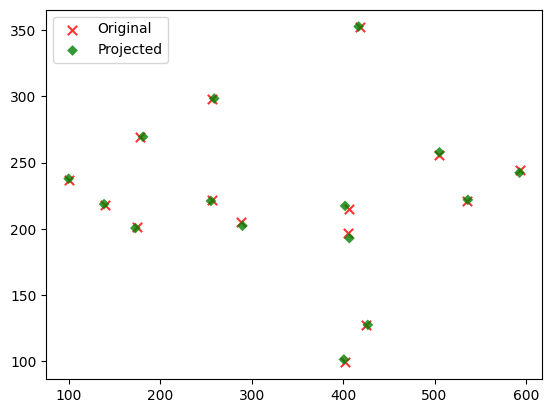

In [ ]:
img2_proj = (H.dot(np.hstack((p1, np.ones((len(p1),1)))).T)).T
img2_proj[:,0] = img2_proj[:,0]/img2_proj[:,2]
img2_proj[:,1] = img2_proj[:,1]/img2_proj[:,2]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(p2[:,0], p2[:,1], alpha=0.8, c='red', edgecolors='none', s=45, label='Original', marker='x')
ax.scatter(img2_proj[:,0], img2_proj[:,1], alpha=0.8, c='green', edgecolors='none', s=30, label='Projected', marker='D')

plt.legend(loc=2)
plt.show()

This is the result for question 2

# Problem 3

In [ ]:
x0 = p2[:,0]
y0 = p2[:,1]

x1 = img2_proj[:,0]
y1 = img2_proj[:,1]

sse = np.sum((x0 - x1)**2 + (y0 - y1)**2)

print("the sum-of-squared error is ", sse)

the sum-of-squared error is  105.97387926939297


# problem 4

<ipython-input-7-af5bf27124c4>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  left =imageio.imread("left.png")
<ipython-input-7-af5bf27124c4>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  right = imageio.imread("right.png")


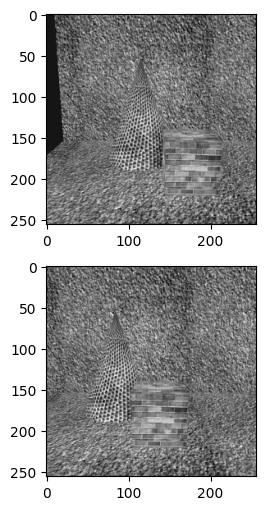

In [ ]:
# read and show the input
left =imageio.imread("left.png")
right = imageio.imread("right.png")

plt.figure(figsize=(6,6))

plt.subplot(2,1,1)
plt.imshow(left,cmap="gray")

plt.subplot(2,1,2)
plt.imshow(right,cmap="gray")

In [ ]:
w, h  = left.shape

#initial the variables
windowSize = 11
max = 50
disparity = np.zeros((w,h))

for i in range(windowSize//2, w-windowSize//2):
    for j in range(windowSize//2, h-windowSize//2):
        # Define the search range
        search_range = min(j - windowSize//2, max)
        # Define the template and search windows
        template = left[i-windowSize//2:i+windowSize//2+1, j-windowSize//2:j+windowSize//2+1]
        best_match = None
        best_ncc = -1
        # Search for the best match within the search range
        for d in range(search_range):
            search_window = right[i-windowSize//2:i+windowSize//2+1, j-windowSize//2-d:j+windowSize//2+1-d]
            # Compute the normalized cross-correlation (NCC) between the template and search window
            ncc = np.sum((template - np.mean(template)) * (search_window - np.mean(search_window))) / (np.std(template) * np.std(search_window) * windowSize**2)
            if ncc > best_ncc:
                best_ncc = ncc
                best_match = d
        # Set the disparity value
        disparity[i, j] = best_match

imageio.imwrite("disparity.png", disparity)

<ipython-input-8-6dcf53dbf8de>:19: RuntimeWarning: invalid value encountered in double_scalars
  ncc = np.sum((template - np.mean(template)) * (search_window - np.mean(search_window))) / (np.std(template) * np.std(search_window) * windowSize**2)


<ipython-input-9-83b62c2c191e>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  finalImg =imageio.imread("disparity.png")


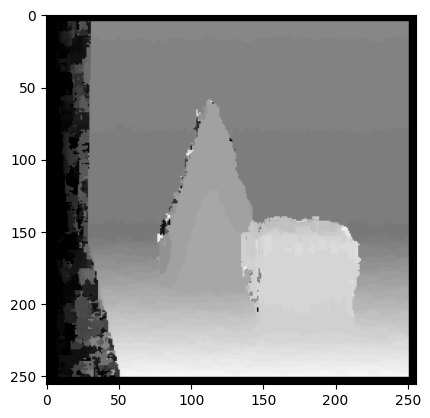

In [ ]:
finalImg =imageio.imread("disparity.png")

plt.imshow(finalImg, cmap='gray')

This is the result for question 4